# Denoising Autoencoders

Denoising is the task of removing noise from a signal, while preserving as much information and features as possible. Due to their inherent properties, Autoencoders are suitable for denoising.

Denoising Autoencoders (DAE) are a particular type of autoencoders that receive corrupted inputs and tries to reconstruct the original, nosie-free input as its output. The training procedure is very similar to the one followed when training a regular autoencoder. The main difference is that the input image is corrupted with some noise and we measure how well the autoencoder is able to remove this corruption.

In this notebook we illustrate this procedure for MNIST and CIFAR-10 datasets.  

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
    This notebook illustrates the tutorial blog post: <b><a href="http://www.angelvillarcorrales.com/templates/tutorials/autoencoders/DenoisingAutoencoders.php">Denoising Autoencoders</a></b><br>
     Therefore, theoretical contents might not completely be explained in detail. Please refer to the post for more in-depth explanations.  
</div> 

In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import lib.models as models
import lib.visualizations as visualizations
import lib.data_handler as data_handler
import lib.utils as utils

Using TensorFlow backend.


In [4]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# loading MNIST dataset
train_set, test_set = data_handler.load_mnist_dataset()

## Creating a noisy dataset

First, we create a noisy MNIST dataset to then denoise using our autoencoder. We do this by adding some Gaussian random noise to the images contained in the dataset.

In [7]:
noise_power = 0.2

train_data = train_set[0]
noisy_train_data = train_set[0] + noise_power*np.random.normal(loc=0.0, scale=1.0, size=train_data.shape) 

test_data = test_set[0]
noisy_test_data = test_set[0] + noise_power*np.random.normal(loc=0.0, scale=1.0, size=test_data.shape) 

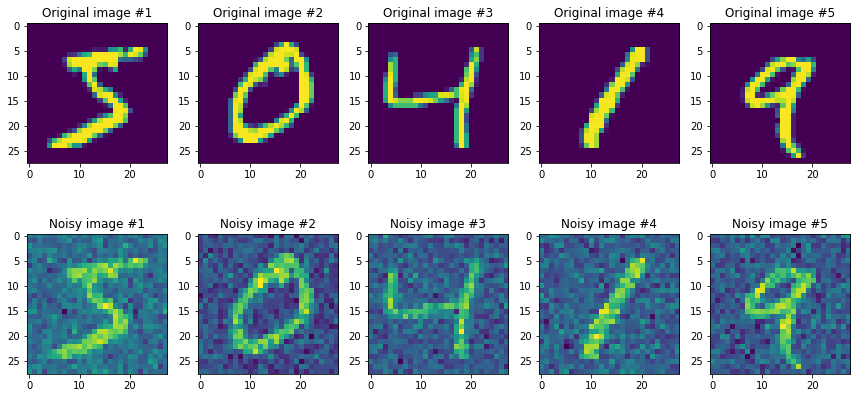

In [8]:
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(train_data[i])
    plt.title(f"Original image #{i+1}")
    plt.subplot(2,5,i+6)
    plt.imshow(noisy_train_data[i])
    plt.title(f"Noisy image #{i+1}")
plt.tight_layout()
plt.show()

## Denoising the Images

To make the autoencoder learn to remove the noise, we feed the noisy images as inputs and we enforce (through the loss function) to reconstruct the original images from the latent-space representation.

The model that we use here is the convolutional autoencoder presented in
<a href="http://www.angelvillarcorrales.com/templates/tutorials/autoencoders/ConvolutionalAutoencoders.php">
Convolutional Autoencoders</a>, and we train with the same settings there presented.

In [9]:
conv_autoencoder, _ = models.basic_conv_autoencoder(bottleneck_dim=10, loss="mse")
conv_autoencoder.summary()

Model: "conv_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               627300    
_________________________________________________________________
bottleneck (Dense)           (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 100)          

In [10]:
# reshaping train and test images to be fed into a conv network
train_data_reshaped, test_data_reshaped = data_handler.prepare_mnist_for_conv(train_data, test_data)
noisy_train_data_reshaped, noisy_test_data_reshaped = data_handler.prepare_mnist_for_conv(noisy_train_data, noisy_test_data)

In [11]:
# notice that we feed noisy_train_data as input and train_data as target
training_log = conv_autoencoder.fit(noisy_train_data_reshaped, train_data_reshaped,
                                    epochs=20, batch_size=1024,
                                    shuffle=True, validation_data=(noisy_test_data_reshaped, test_data_reshaped))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 99us/step - loss: 0.0634 - val_loss: 0.0450
Epoch 2/20
60000/60000 [==============================] - 1s 25us/step - loss: 0.0377 - val_loss: 0.0327
Epoch 3/20
60000/60000 [==============================] - 2s 25us/step - loss: 0.0311 - val_loss: 0.0290
Epoch 4/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.0285 - val_loss: 0.0272
Epoch 5/20
60000/60000 [==============================] - 2s 26us/step - loss: 0.0270 - val_loss: 0.0262
Epoch 6/20
60000/60000 [==============================] - 2s 29us/step - loss: 0.0255 - val_loss: 0.0244
Epoch 7/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.0241 - val_loss: 0.0234
Epoch 8/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.0232 - val_loss: 0.0226
Epoch 9/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.0226 - val_loss: 0.0223
Epoch

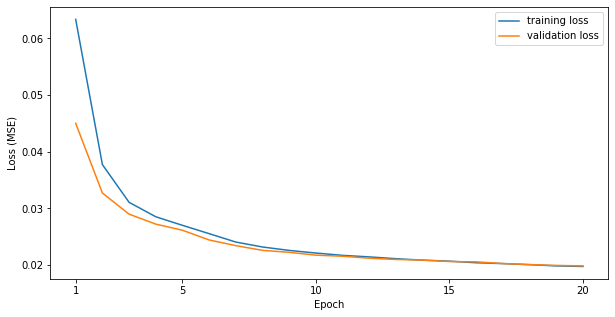

In [12]:
training_loss = training_log.history["loss"]
validation_loss = training_log.history["val_loss"]

plt.figure(figsize=(10,5))
plt.plot(training_loss, label="training loss")
plt.plot(validation_loss, label="validation loss")
plt.legend(loc="best")
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.xticks([0,4,9,14,19],[1,5,10,15,20])
plt.show()

In [13]:
# encoding and decoding the MNIST test set
denoised_imgs = conv_autoencoder.predict(noisy_test_data_reshaped)

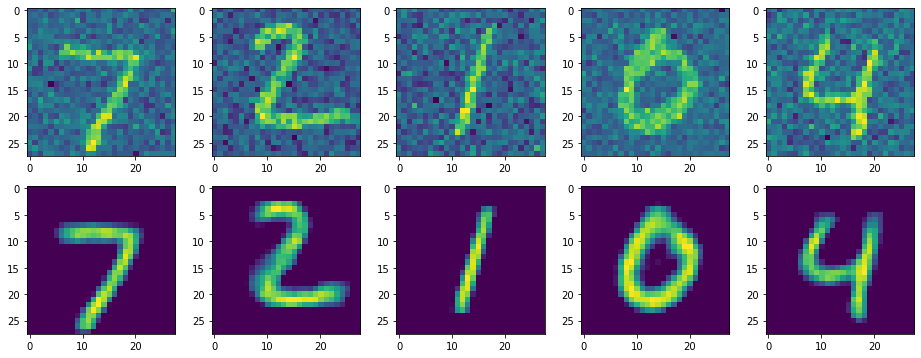

In [14]:
# displaying some of the images before encodeing and after decoding
visualizations.display_original_and_decoded_imgs(img_original=noisy_test_data_reshaped[:,:,:,0],
                                                 img_decoded=denoised_imgs[:,:,:,0], n_images=5,
                                                 idx=[0,1,2,3,4])

The previous plots display some of the noisy images (top row) and their counterparts denoised by our autoencoder (bottom row). We can see how the reconstructions are not only clear image numbers representing the original digits, but also almost perfectly denoised.

## Experiments on CIFAR-10

We have seen that we can successfully denoise MNIST images using a convolutional denoising autonecoder. Nevertheless, MNIST can be considered almost a toy dataset due to the simplicity of the images there contained.

In this section we repeat a similar experiment but using images from the CIFAR-10 dataset. We will investigate if convolutional autoencoders are able to denoise color images while preserving (up to some extent) the image content.

In [15]:
# downloading and loading the data and labels
cifar_train, cifar_test = data_handler.load_ciphar_data()

# normalizing values to [0, 1]
train_data = cifar_train[0]/255
test_data = cifar_test[0]/255

In [16]:
noise_power = 0.3

noisy_train_data = train_data + noise_power*np.random.normal(loc=0.0, scale=1.0, size=train_data.shape) 
noisy_test_data = test_data + noise_power*np.random.normal(loc=0.0, scale=1.0, size=test_data.shape) 

# cutting values above 1 and below 0
noisy_train_data = np.clip(noisy_train_data, a_min=0, a_max=1)
noisy_test_data = np.clip(noisy_test_data, a_min=0, a_max=1)

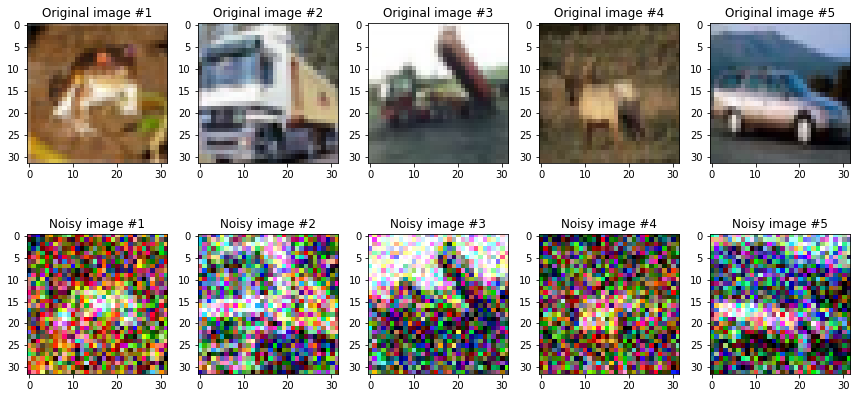

In [17]:
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(train_data[i])
    plt.title(f"Original image #{i+1}")
    plt.subplot(2,5,i+6)
    plt.imshow(noisy_train_data[i])
    plt.title(f"Noisy image #{i+1}")
plt.tight_layout()
plt.show()

In [18]:
# setting up a more complex model, very similar to the one in the figure at the beginning of the notebook
cifar_autoencoder, _ = models.ciphar_conv_autoencoder(bottleneck_dim=128, loss="mse")
cifar_autoencoder.summary()

Model: "conv_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)         

In [19]:
training_log = cifar_autoencoder.fit(noisy_train_data, train_data,
                                     epochs=20, batch_size=256,
                                     shuffle=True, validation_data=(noisy_test_data, test_data))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 10s 192us/step - loss: 0.0453 - val_loss: 0.0255
Epoch 2/20
50000/50000 [==============================] - 8s 156us/step - loss: 0.0226 - val_loss: 0.0224
Epoch 3/20
50000/50000 [==============================] - 7s 147us/step - loss: 0.0191 - val_loss: 0.0175
Epoch 4/20
50000/50000 [==============================] - 7s 137us/step - loss: 0.0171 - val_loss: 0.0167
Epoch 5/20
50000/50000 [==============================] - 6s 130us/step - loss: 0.0162 - val_loss: 0.0159
Epoch 6/20
50000/50000 [==============================] - 7s 132us/step - loss: 0.0155 - val_loss: 0.0162
Epoch 7/20
50000/50000 [==============================] - 7s 131us/step - loss: 0.0150 - val_loss: 0.0147
Epoch 8/20
50000/50000 [==============================] - 6s 126us/step - loss: 0.0146 - val_loss: 0.0143
Epoch 9/20
50000/50000 [==============================] - 7s 145us/step - loss: 0.0144 - val_loss: 0.

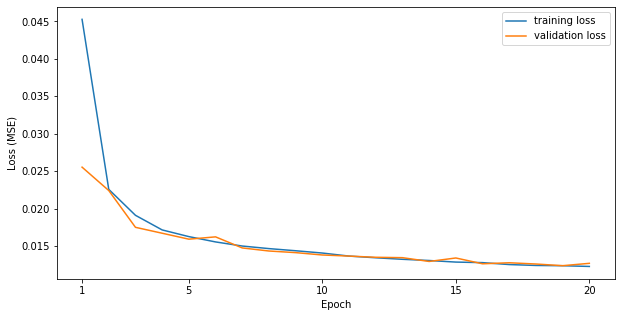

In [20]:
training_loss = training_log.history["loss"]
validation_loss = training_log.history["val_loss"]

plt.figure(figsize=(10,5))
plt.plot(training_loss, label="training loss")
plt.plot(validation_loss, label="validation loss")
plt.legend(loc="best")
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.xticks([0,4,9,14,19],[1,5,10,15,20])
plt.show()

In [21]:
# encoding and decoding the noisy CIFAR test set
denoised_imgs = cifar_autoencoder.predict(noisy_test_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


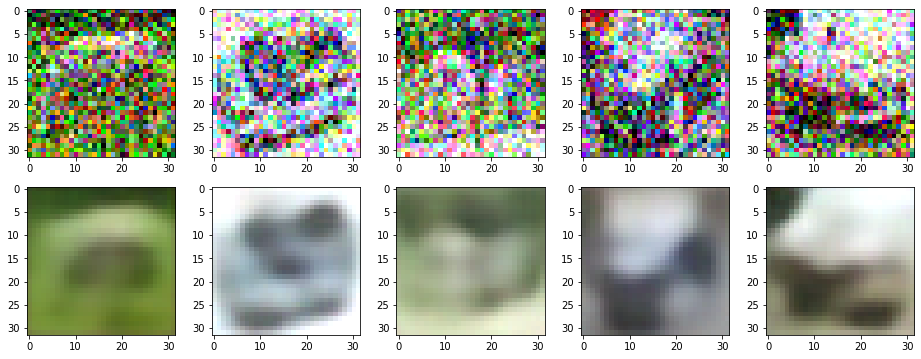

In [22]:
# displaying some of the images before encodeing and after decoding
visualizations.display_original_and_decoded_imgs(img_original=noisy_test_data,
                                                 img_decoded=denoised_imgs, n_images=5)

Despite the fact that the autoencoder is not able to recover the complete high frequency information in the image, it succeeds at removing the gaussian additive noise that we have added to all three channels.

Therefore, we can conclude saying that autoencoders excel at the task of denoising images that have been corrupted using additive gaussian noise.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
    This notebook was created by <b>Angel Villar-Corrales</b>
</div> 